In [12]:
# Importation des librairies
import pandas as pd
import numpy as np
from time import time
import seaborn as sns
from scipy.stats import f_oneway
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# **I Retouche sur les données**

**1.Exportation de la base**

**2.Modification des libellés des colonnes**

In [13]:
# Importation de la base
base = pd.read_csv("../Data/WalmartSQL_repository.csv", sep=";")

In [14]:
#visiualisation de la base
base.head(2)

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,vat,total,dtme,tme,payment_method,cogs,gross_margin_pct,gross_income,rating,time_of_day,day_name,month_name
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05 00:00:00,13:08:00,Ewallet,522.83,4.7619,26.1415,9.1,afternoon,Saturday,January
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08 00:00:00,10:29:00,Cash,76.40,4.7619,3.8200,9.6,morning,Friday,March


In [15]:
# modification des libellés de colonnes
base.columns = ['id', 'succursale', 'ville', 'type_client', 'sexe',
       'game_produit', 'prix_unitaire', 'quantité', 'taxe', 'prix_total', 'date', 'heure',
       'mode_paiement', 'cout', 'brut', 'revenu', 'notation',
       'moment', 'jour', 'mois']
base.head(2)

,id,succursale,ville,type_client,sexe,game_produit,prix_unitaire,quantité,taxe,prix_total,date,heure,mode_paiement,cout,brut,revenu,notation,moment,jour,mois
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05 00:00:00,13:08:00,Ewallet,522.83,4.7619,26.1415,9.1,afternoon,Saturday,January
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08 00:00:00,10:29:00,Cash,76.40,4.7619,3.8200,9.6,morning,Friday,March


# **II Analyse exploratoire**

**Notes**
- **Analyse de forme**
    - Nombres de colonnes: **19 [12(object), 7(float64), 1(in64)]**.
    - Nombre de lignes: **1000**.
    - **0** variables manquantes.
    - les variables **heure** et **date** peuvent être représenter par **jour**, **mois** et **moment**.
    - la variable Id a 1000 valeurs unique (pas d'information).
    - la variable **brut** à une seule seule valeur (pas d'information).
  
- **Analyse de fond**
  - **Analyse univariée**
    - Les variables numériques ont des échelles différentes.
    - Taxe, prix total, cout et pourcentage marge contiennent des valeurs abbérantes.
    - Absence de modalités négligeable dans les variable qualitatives.
    - On note une parfaite corrélation entre la variable **revenu** et (prix total, taxe et cout).
  
- **Prétraitement de données**
  - **Variables à eliminés**
    - Date, heure, id, brut, prix_total, taxe et cout **(valeurs inutiles et multicorélation)**.
  - **Modification**
    - les variables qualitatives vont être encoder.
    - les valeurs abbérantes de **revenu** doivent être imputer.
    - **Normalisation** des variables aprés encodage.

# **III Analyse de forme**

**1.Information sur les données**

**2.Création des deux listes de libellés des colonnes qualitatives et quantitatives**


In [16]:
# 1.visualisation des infos de la base
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   object 
 1   succursale     1000 non-null   object 
 2   ville          1000 non-null   object 
 3   type_client    1000 non-null   object 
 4   sexe           1000 non-null   object 
 5   game_produit   1000 non-null   object 
 6   prix_unitaire  1000 non-null   float64
 7   quantité       1000 non-null   int64  
 8   taxe           1000 non-null   float64
 9   prix_total     1000 non-null   float64
 10  date           1000 non-null   object 
 11  heure          1000 non-null   object 
 12  mode_paiement  1000 non-null   object 
 13  cout           1000 non-null   float64
 14  brut           1000 non-null   float64
 15  revenu         1000 non-null   float64
 16  notation       1000 non-null   float64
 17  moment         1000 non-null   object 
 18  jour     

In [17]:
# créer le liste des variables quantitatives
Numcols = base.drop('brut',axis=1).select_dtypes(exclude= 'object').columns.to_list()
Numcols

['prix_unitaire',
 'quantité',
 'taxe',
 'prix_total',
 'cout',
 'revenu',
 'notation']

In [18]:
# créer le liste de variables qualitatives
CatCols = base.drop('id', axis=1).select_dtypes(include='object').columns.to_list()
CatCols

['succursale',
 'ville',
 'type_client',
 'sexe',
 'game_produit',
 'date',
 'heure',
 'mode_paiement',
 'moment',
 'jour',
 'mois']

# **IV Analyse Univariée**

**1.Visualisation des statistiques des valeurs quantitatives et qualitatives**

**2.Verifier la distribution des valeurs quanti et quali**

In [19]:
# Verification des statistiques des valeurs numériques
base[Numcols].describe().T

,count,mean,std,min,25%,50%,75%,max
prix_unitaire,1000.0,55.672130,26.494628,10.0800,32.875000,55.230,77.93500,99.96
quantité,1000.0,5.510000,2.923431,1.0000,3.000000,5.000,8.00000,10.00
taxe,1000.0,15.379369,11.708825,0.5085,5.924875,12.088,22.44525,49.65
prix_total,1000.0,322.966749,245.885335,10.6785,124.422375,253.848,471.35025,1042.65
cout,1000.0,307.587380,234.176510,10.1700,118.497500,241.760,448.90500,993.00
revenu,1000.0,15.379369,11.708825,0.5085,5.924875,12.088,22.44525,49.65
notation,1000.0,6.972700,1.718580,4.0000,5.500000,7.000,8.50000,10.00


In [20]:
# Explorer la description des variables qualitatives
base[CatCols].describe().T

,count,unique,top,freq
succursale,1000,3,A,340
ville,1000,3,Yangon,340
type_client,1000,2,Member,501
sexe,1000,2,Female,501
game_produit,1000,6,Fashion accessories,178
date,1000,89,2019-02-07 00:00:00,20
heure,1000,506,19:48:00,7
mode_paiement,1000,3,Ewallet,345
moment,1000,3,evening,432
jour,1000,7,Saturday,164


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


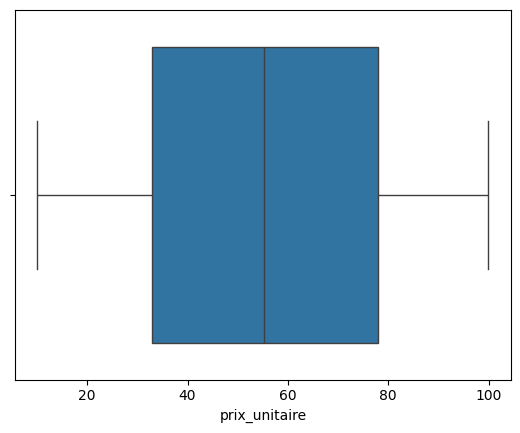

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


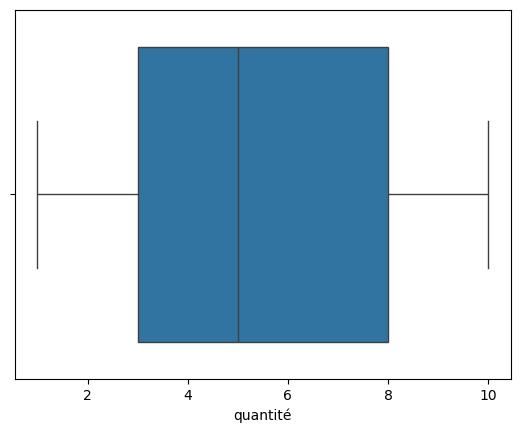

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


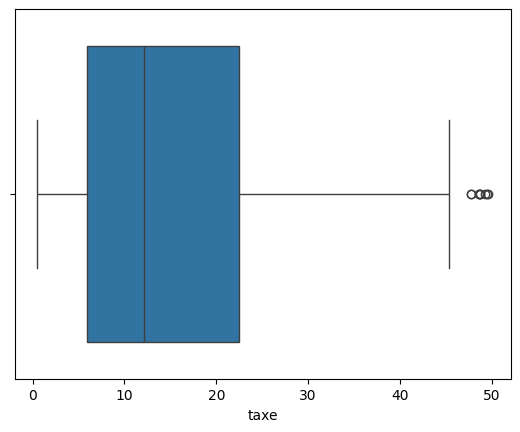

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


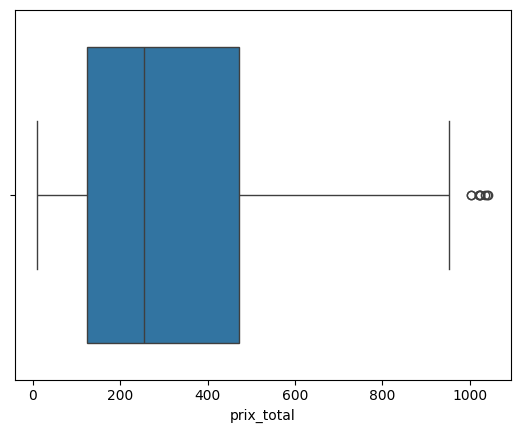

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


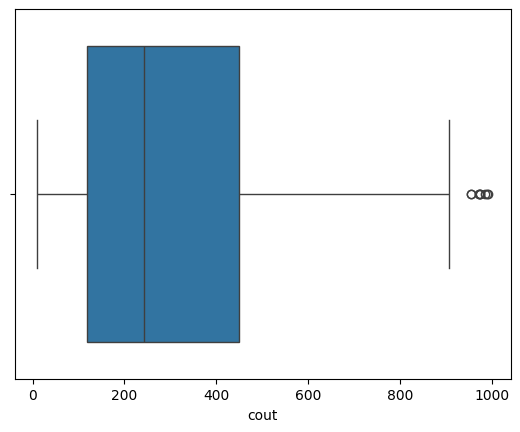

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


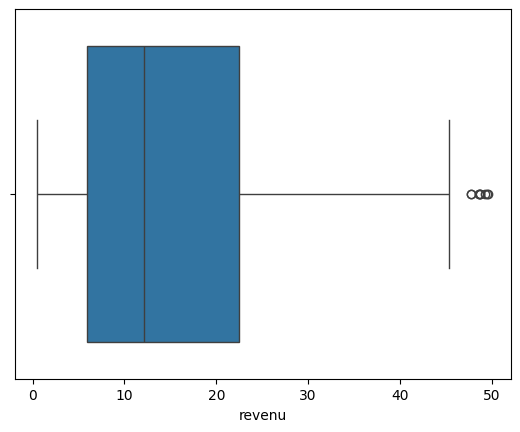

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


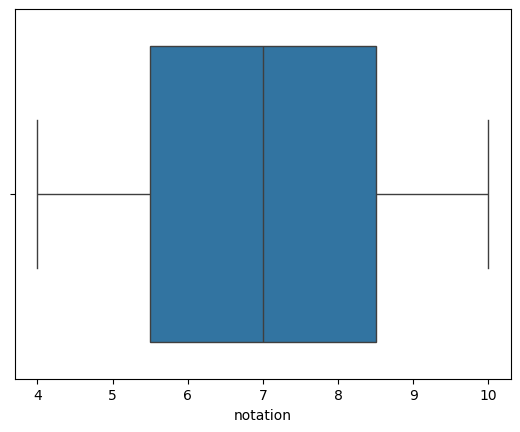

In [21]:
# Verifier les valeurs aberrantes
for var in Numcols:
    plt.figure()
    sns.boxplot(base, x = var)
    plt.show()

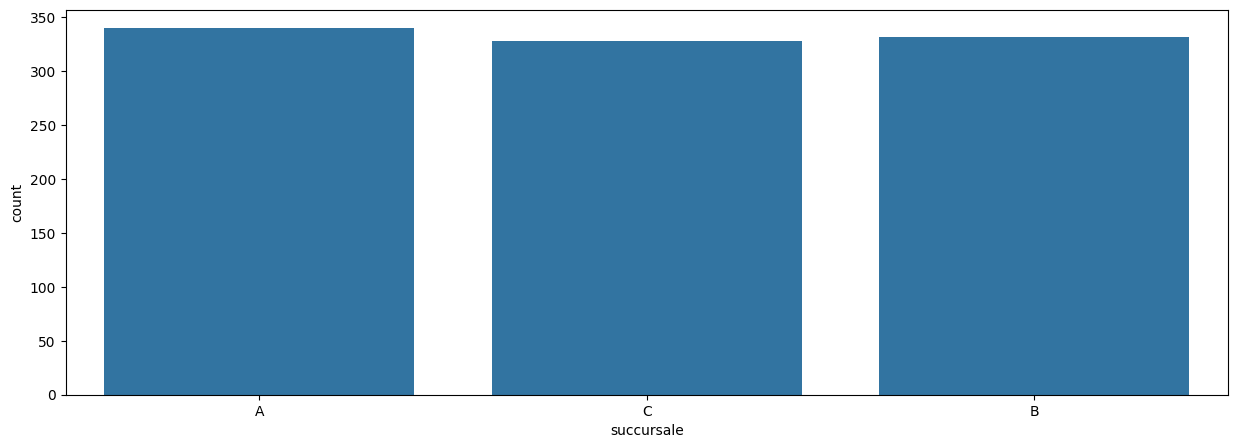

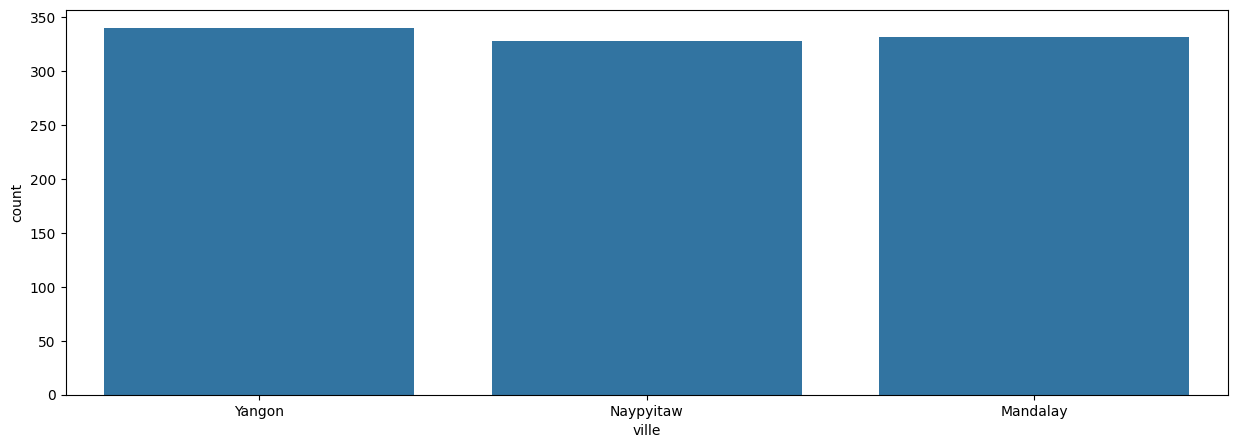

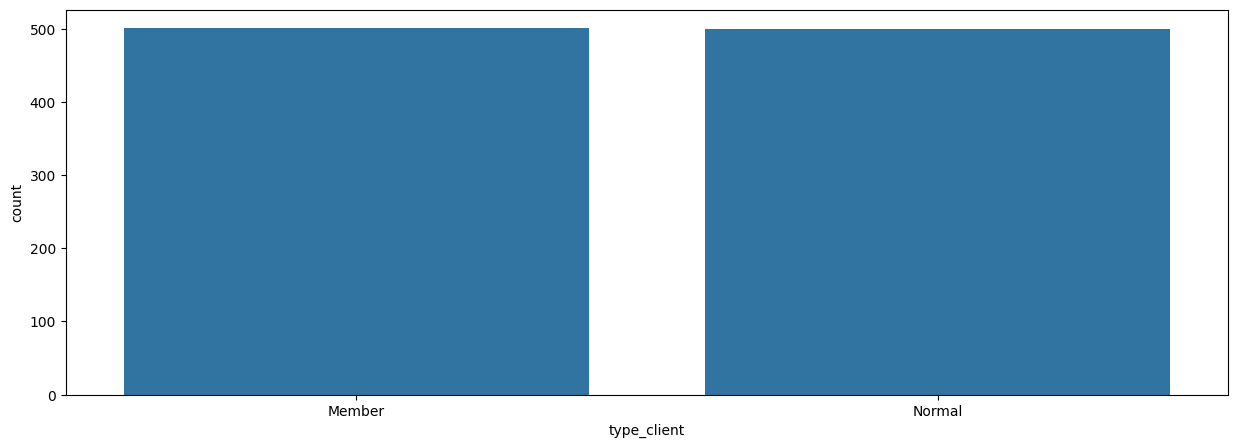

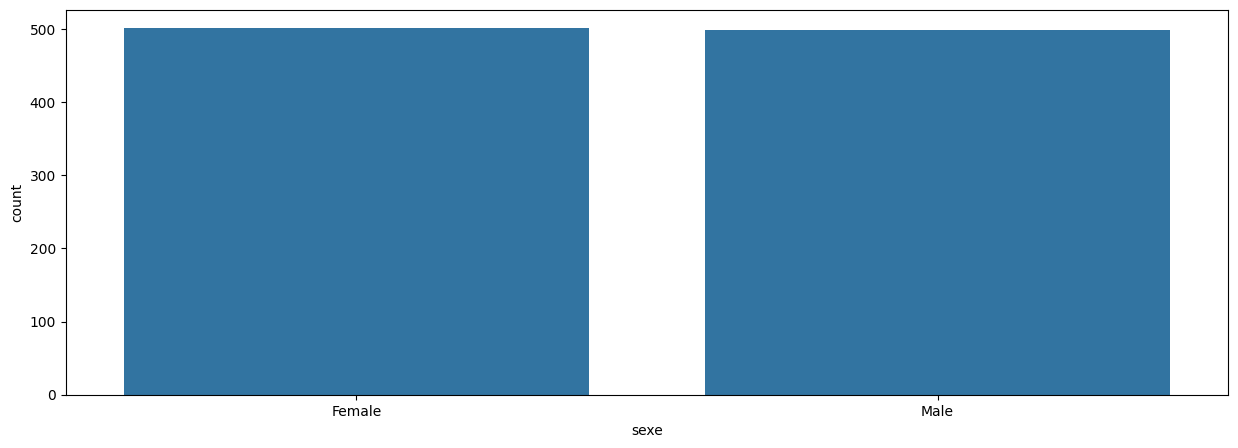

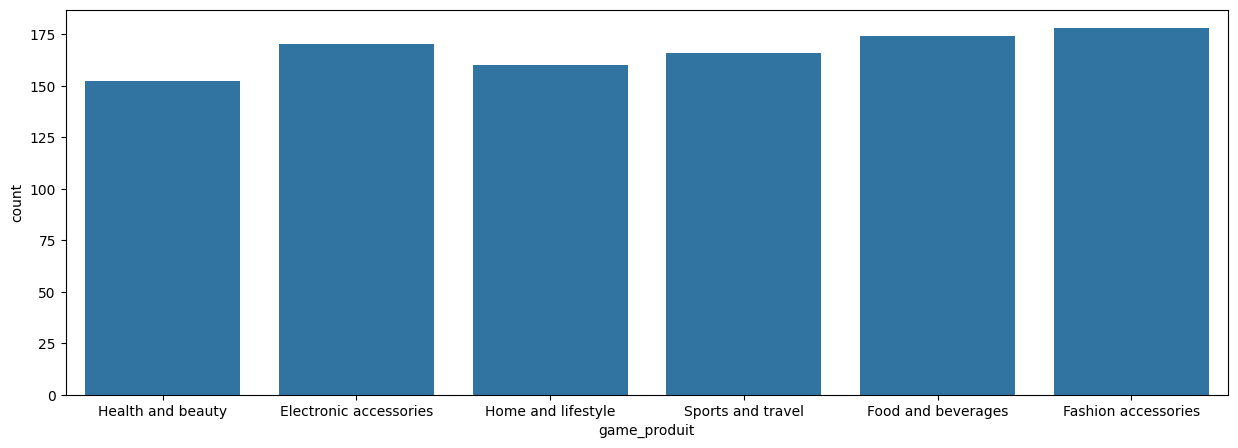

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

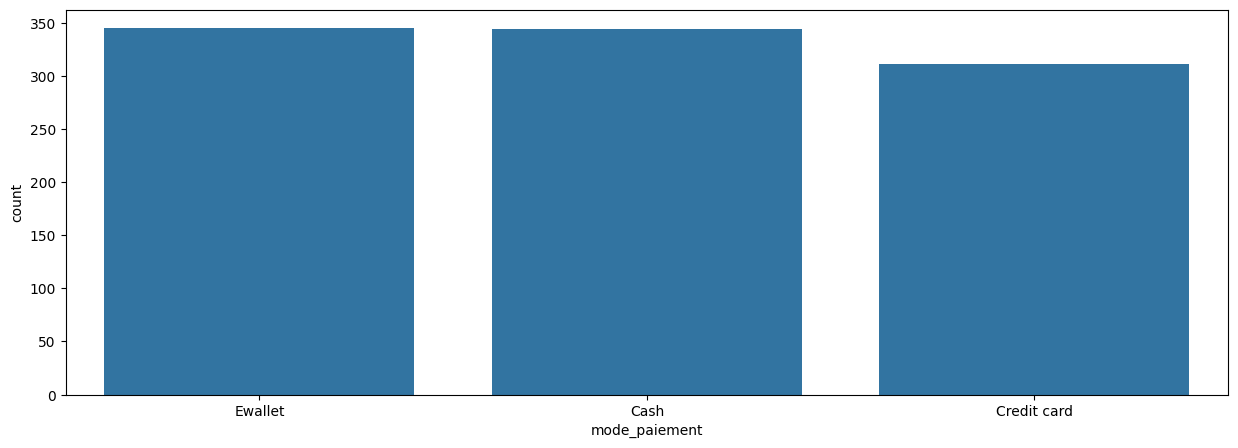

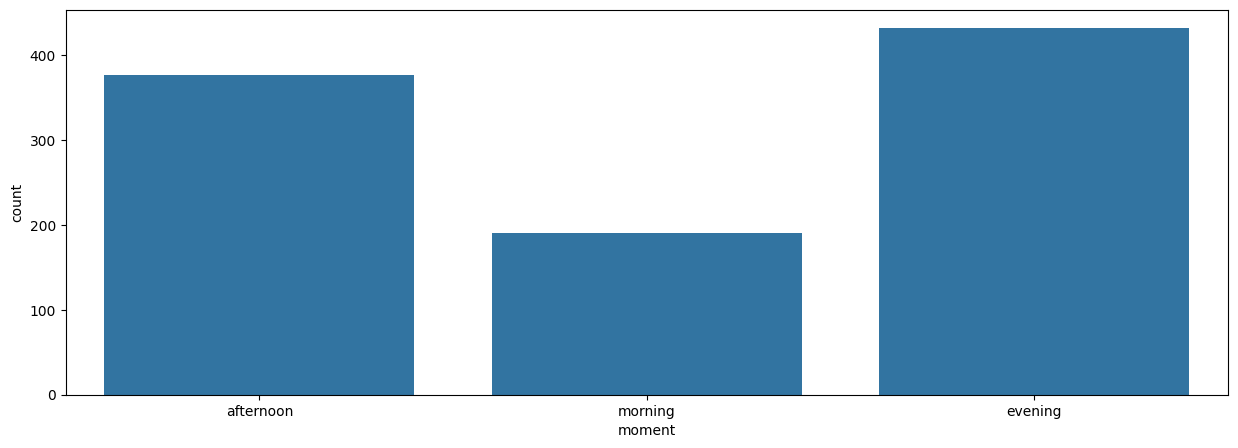

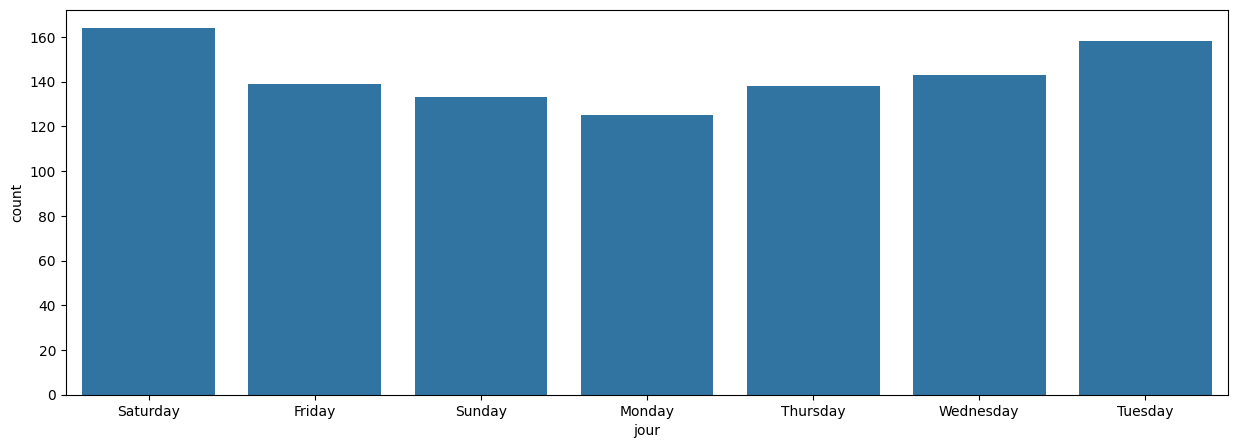

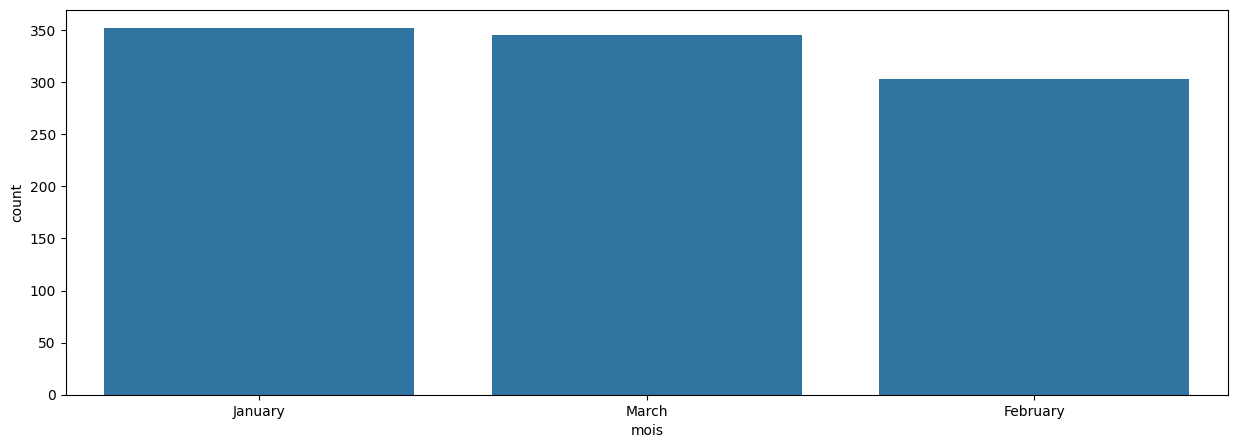

In [22]:
# Visualiser la distribution des variables qualitatives
for var in CatCols:
    plt.figure(figsize=(15,5))
    if var!= 'heure' and var != 'date':
        sns.countplot(base, x=var)
        plt.show()

# **V Analyse Multivariée**

**1.Etude des relations bivariées**

<Axes: >

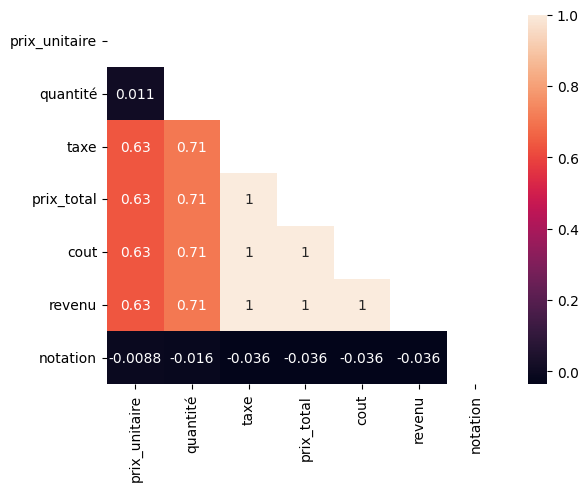

In [23]:
# Verifier la corrélation des variables quantitatives
heatmap_cor = base[Numcols].corr()
sns.heatmap(heatmap_cor, annot=True, fmt= ".2g", mask=np.triu(heatmap_cor))

# **VI Prétraitement de données**

**1.Suppression des variables inutiles(pas d'infos)**

**2.Encodage des variables qualitatives(pour une maniplation des données plus facile)**

**3.Calcul des outliers du dataset**

In [24]:
# Suppression des valeurs inutiles
df_base = base.drop(['id', 'date', 'heure', 'brut', 'prix_total', 'taxe', 'cout'], axis=1)

df_base.head(4)

,succursale,ville,type_client,sexe,game_produit,prix_unitaire,quantité,mode_paiement,revenu,notation,moment,jour,mois
0,A,Yangon,Member,Female,Health and beauty,74.69,7,Ewallet,26.1415,9.1,afternoon,Saturday,January
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,Cash,3.8200,9.6,morning,Friday,March
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,Credit card,16.2155,7.4,afternoon,Sunday,March
3,A,Yangon,Member,Male,Health and beauty,58.22,8,Ewallet,23.2880,8.4,evening,Sunday,January


In [25]:
# Suppression des libellé inutiles dans les listes
for var in ['id', 'date', 'heure', 'brut', 'prix_total', 'taxe', 'cout']:
    if var in CatCols:
        CatCols.remove(var)

for var in ['id', 'date', 'heure', 'brut', 'prix_total', 'taxe', 'cout']:
    if var in Numcols:
        Numcols.remove(var)

print(f"NumCols: {Numcols}\n \n \nCatCols: {CatCols}")

NumCols: ['prix_unitaire', 'quantité', 'revenu', 'notation']
 
 
CatCols: ['succursale', 'ville', 'type_client', 'sexe', 'game_produit', 'mode_paiement', 'moment', 'jour', 'mois']


In [26]:
# Verification les modalités des variables
for var in CatCols:
    print(f"{var}:  {df_base[CatCols][var].unique()}\n\n")

succursale:  ['A' 'C' 'B']


ville:  ['Yangon' 'Naypyitaw' 'Mandalay']


type_client:  ['Member' 'Normal']


sexe:  ['Female' 'Male']


game_produit:  ['Health and beauty' 'Electronic accessories' 'Home and lifestyle'
 'Sports and travel' 'Food and beverages' 'Fashion accessories']


mode_paiement:  ['Ewallet' 'Cash' 'Credit card']


moment:  ['afternoon' 'morning' 'evening']


jour:  ['Saturday' 'Friday' 'Sunday' 'Monday' 'Thursday' 'Wednesday' 'Tuesday']


mois:  ['January' 'March' 'February']




In [27]:
# Encodage des variables qualitatives
df_base_encode = pd.DataFrame()
Ordinal_encoder = OrdinalEncoder()

for var in df_base.columns:
    if var in CatCols:
        # Encoder les variables catégorielles et les ajouter au DataFrame encodé
        encoded_var = Ordinal_encoder.fit_transform(df_base[[var]]).astype(int)
        df_base_encode[var] = encoded_var.flatten()  # Ajouter la colonne encodée
    elif var in Numcols:
        df_base_encode[var] = df_base[var]

# visualisation des 10 premiers ligne de la base encoder
df_base_encode.head(10)

,succursale,ville,type_client,sexe,game_produit,prix_unitaire,quantité,mode_paiement,revenu,notation,moment,jour,mois
0,0,2,0,0,3,74.69,7,2,26.1415,9.1,0,2,1
1,2,1,1,0,0,15.28,5,0,3.8200,9.6,2,0,2
2,0,2,1,1,4,46.33,7,1,16.2155,7.4,0,3,2
3,0,2,0,1,3,58.22,8,2,23.2880,8.4,1,3,1
4,0,2,1,1,5,86.31,7,2,30.2085,5.3,2,0,0
5,2,1,1,1,0,85.39,7,2,29.8865,4.1,1,1,2
6,0,2,0,0,0,68.84,6,2,20.6520,5.8,0,1,0
7,2,1,1,0,4,73.56,10,2,36.7800,8.0,2,3,0
8,0,2,0,0,3,36.26,2,1,3.6260,7.2,1,4,1
9,1,0,0,0,2,54.84,3,1,8.2260,5.9,0,6,0


In [28]:
# Creation de la fonction de genération du Dataframe des encodages

def CodeFrame(Df, CatList):
    # Créer un DataFrame pour stocker les valeurs uniques
    Df = pd.DataFrame(
        [np.unique(Df[var]) for var in CatList]).T

    Df.columns = CatList  # Utiliser directement CatList comme colonnes
    return Df

# Créer un DataFrame vide pour stocker les valeurs uniques
df_code = pd.DataFrame()

# Utiliser la fonction CodeFrame pour créer le DataFrame avec les valeurs uniques
df_code = CodeFrame(df_base, CatCols)

df_code.fillna('', inplace=True)

df_code

,succursale,ville,type_client,sexe,game_produit,mode_paiement,moment,jour,mois
0,A,Mandalay,Member,Female,Electronic accessories,Cash,afternoon,Friday,February
1,B,Naypyitaw,Normal,Male,Fashion accessories,Credit card,evening,Monday,January
2,C,Yangon,,,Food and beverages,Ewallet,morning,Saturday,March
3,,,,,Health and beauty,,,Sunday,
4,,,,,Home and lifestyle,,,Thursday,
5,,,,,Sports and travel,,,Tuesday,
6,,,,,,,,Wednesday,


In [29]:
# Verification des échelles aprés encodage
df_base_encode.describe().T

,count,mean,std,min,25%,50%,75%,max
succursale,1000.0,0.988000,0.817633,0.0000,0.000000,1.000,2.00000,2.00
ville,1000.0,1.008000,0.820127,0.0000,0.000000,1.000,2.00000,2.00
type_client,1000.0,0.499000,0.500249,0.0000,0.000000,0.000,1.00000,1.00
sexe,1000.0,0.499000,0.500249,0.0000,0.000000,0.000,1.00000,1.00
game_produit,1000.0,2.452000,1.715412,0.0000,1.000000,2.000,4.00000,5.00
prix_unitaire,1000.0,55.672130,26.494628,10.0800,32.875000,55.230,77.93500,99.96
quantité,1000.0,5.510000,2.923431,1.0000,3.000000,5.000,8.00000,10.00
mode_paiement,1000.0,1.001000,0.830475,0.0000,0.000000,1.000,2.00000,2.00
revenu,1000.0,15.379369,11.708825,0.5085,5.924875,12.088,22.44525,49.65
notation,1000.0,6.972700,1.718580,4.0000,5.500000,7.000,8.50000,10.00


In [30]:
# Création de la fonction de gestion des outliers
def inputOutlier(df, var):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    min = Q1 - 1.5 * IQR
    max = Q3 + 1.5 * IQR
    
    
    # Remplacer les valeurs aberrantes par les valeurs seuil
    df[var] = df[var].clip(min, max)

    return df

In [31]:
# Appliquer la fonction des outliers à tous les variables numériques
for var in Numcols:
   df_base_encode = inputOutlier(df_base_encode, var)

# **VII Vérification du préraitement**

**1.Derniére vérification des modifications antérieurs**

In [32]:
# verification de la base encodé
df_base_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   succursale     1000 non-null   int32  
 1   ville          1000 non-null   int32  
 2   type_client    1000 non-null   int32  
 3   sexe           1000 non-null   int32  
 4   game_produit   1000 non-null   int32  
 5   prix_unitaire  1000 non-null   float64
 6   quantité       1000 non-null   int64  
 7   mode_paiement  1000 non-null   int32  
 8   revenu         1000 non-null   float64
 9   notation       1000 non-null   float64
 10  moment         1000 non-null   int32  
 11  jour           1000 non-null   int32  
 12  mois           1000 non-null   int32  
dtypes: float64(3), int32(9), int64(1)
memory usage: 66.5 KB


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


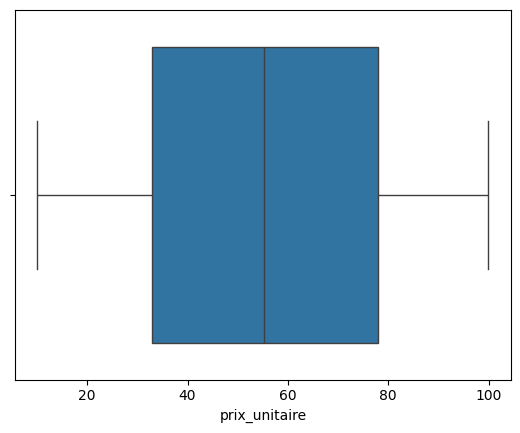

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


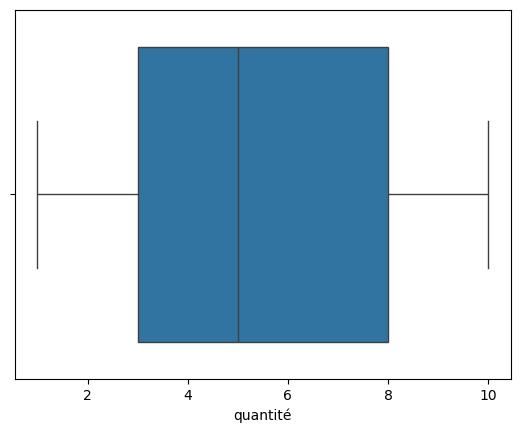

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


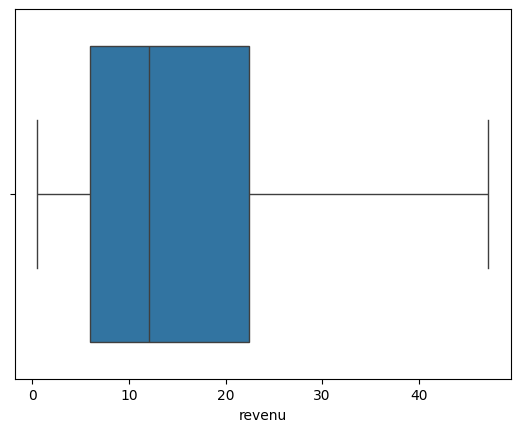

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


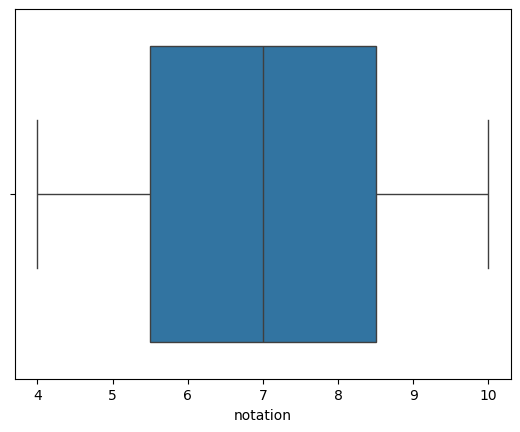

In [33]:
# Verification des outliers
for var in Numcols:
    plt.figure()
    sns.boxplot(df_base_encode, x= var)
    plt.show()

# **VIII Préparation de la base pour modélisation**

   **1.Division de la base en variables explicatives et variable cible**

   **2.Departager la base en données d'entrainement et données de test**
   
   **3.Standardisation des variables explicatives (Train and test)**

In [34]:
# Division de la base
X = df_base_encode.drop('revenu', axis=1)
Y = df_base_encode['revenu']

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=41)

In [36]:
print(f"Dimension de X_train = ",{X_train.shape})
print(f"Dimension de Y_train = ",{Y_train.shape})

Dimension de X_train =  {(800, 12)}
Dimension de Y_train =  {(800,)}


In [37]:
# Standardisation des variables quanti pour une méme échelle

#instanciation
scaler = StandardScaler()

Numcols.remove('revenu')

In [38]:
# standardisation de X_train
X_train_scaled = X_train.copy()

X_train_scaled.loc[:, Numcols] = scaler.fit_transform(X_train[Numcols])

C:\Users\HP\AppData\Local\Temp\ipykernel_15932\1623178572.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50425381  0.17430472 -0.16497454 -1.5220916  -0.50425381  1.19214251
 -0.16497454 -0.84353307  1.53142178  0.51358399  0.85286325 -1.18281233
  1.53142178  0.85286325 -0.50425381 -0.50425381  0.85286325  0.85286325
  1.53142178  1.53142178  0.85286325  0.51358399 -0.16497454  1.53142178
  1.53142178  1.53142178 -0.84353307 -1.5220916  -1.18281233  0.17430472
  0.85286325 -0.50425381 -1.18281233 -0.50425381  1.53142178  0.51358399
 -0.50425381  0.17430472  0.17430472 -0.84353307  1.19214251 -0.50425381
 -1.5220916   0.51358399  0.17430472  1.19214251 -0.84353307 -1.5220916
  1.53142178 -1.5220916   1.53142178 -1.18281233  0.85286325  0.17430472
 -0.16497454 -0.84353307  0.51358399 -0.16497454 -1.18281233 -0.84353307
  1.53142178  0.85286325  0.17430472 -0.84353307 -0.16497454  1.19214251
  1.53142178 -1.

In [39]:
# standardisation de X_test
X_test_scaled = X_test.copy()

X_test_scaled.loc[:, Numcols] = scaler.transform(X_test[Numcols])

C:\Users\HP\AppData\Local\Temp\ipykernel_15932\3901042306.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.84353307  0.17430472 -1.5220916   1.53142178  1.53142178 -1.5220916
  1.19214251 -0.16497454 -1.18281233  0.51358399 -0.50425381 -1.5220916
  0.51358399 -0.84353307  1.19214251 -0.84353307 -1.5220916  -0.84353307
  0.17430472 -1.5220916   0.17430472 -0.84353307 -0.16497454  0.85286325
  1.53142178 -0.16497454  1.19214251  1.53142178 -0.50425381  0.51358399
 -0.16497454  0.85286325  0.85286325 -0.16497454 -1.18281233 -0.16497454
  1.19214251 -1.18281233  1.53142178 -1.5220916   0.85286325 -0.50425381
  1.19214251  1.53142178  0.51358399  0.51358399  1.53142178 -1.5220916
  1.19214251  0.85286325  1.53142178 -1.18281233 -1.18281233  0.51358399
 -1.18281233  1.19214251  0.17430472 -0.50425381 -0.84353307  0.51358399
  1.19214251  0.51358399  0.51358399  0.17430472  0.17430472 -1.18281233
  1.53142178  0.85

# **IX Choix du meilleur modéle**

**1.Entraînement et Test de plusieurs modéles sur le dataset**

**2.Test d'ANOVA sur les variables qualitatives du dataset**

In [40]:
## Fonction de la  modélisation
scores = []
def modelisation(models, x_train, y_train, x_test, y_test ):
    for model in models:
        print(type(model).__name__,)
        #instanciation
        mod = model()
        debut = time()
        mod.fit(x_train, y_train)
        fin = time()
        predict = mod.predict(x_test)
        scores.append({"modele": type(mod).__name__,
                       "temps": fin-debut,
                       "score_train": mod.score(x_train, y_train),
                       "score_test": mod.score(x_test, y_test),
                       "MSE": mean_squared_error(y_test, predict),
                       "MAE": mean_absolute_error(y_test, predict),
                       "MAPE": mean_absolute_percentage_error(y_test, predict)}),
    return pd.DataFrame(scores)

In [41]:
mode_list= [KNeighborsRegressor, LinearRegression, SVR, 
            RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor]

In [42]:
modelisation(mode_list, X_train_scaled, Y_train,
                        X_test_scaled, Y_test)

ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta


,modele,temps,score_train,score_test,MSE,MAE,MAPE
0,KNeighborsRegressor,0.019751,0.856788,0.787525,30.665061,4.298388,0.491235
1,LinearRegression,0.008009,0.889563,0.898780,14.608411,2.937750,0.485146
2,SVR,0.181751,0.879362,0.867850,19.072217,2.941236,0.238320
3,RandomForestRegressor,2.269990,0.999704,0.998244,0.253359,0.335293,0.028317
4,AdaBoostRegressor,0.328000,0.970648,0.969527,4.397927,1.738786,0.237043
5,GradientBoostingRegressor,0.470999,0.999171,0.998262,0.250896,0.355535,0.036066


In [43]:
# Initialiser une liste pour stocker les résultats
resultats_anova = []

# Effectuer l'ANOVA pour chaque colonne
for colonne in df_base[CatCols]:
    groupes = [df_base[df_base[colonne] == modalite]['revenu'] for modalite in df_base[colonne].unique()]
    statistique_anova, valeur_p = f_oneway(*groupes)
    resultat = {'Variable': colonne,
                'Statistique_ANOVA': statistique_anova,
                'Valeur_p': valeur_p}
    resultats_anova.append(resultat)

# Convertir la liste de résultats en DataFrame
df_resultats_anova = pd.DataFrame(resultats_anova)

# Afficher les résultats
df_resultats_anova

,Variable,Statistique_ANOVA,Valeur_p
0,succursale,0.884583,0.413210
1,ville,0.884583,0.413210
2,type_client,0.386296,0.534395
3,sexe,2.446492,0.118105
4,game_produit,0.337965,0.890040
5,mode_paiement,0.081104,0.922104
6,moment,0.049459,0.951746
7,jour,0.497562,0.810490
8,mois,0.263365,0.768515
